### CS 5190 Assignment 2
### Johnson Wei (004150718)

In [171]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

In [172]:
# Creating a function to display images side by side so that we can visually compare the two.
# Result: image1 and image2 will displayed left to right, respectively.
def postPicsSideBySide(image1, image2):
    pic = plt.figure()
    pic.set_figheight(10)
    pic.set_figwidth(10)
    pic.add_subplot(1,2,1)
    plt.imshow(image1, cmap='gray')

    # add image2
    pic.add_subplot(1,2,2)
    plt.imshow(image2, cmap='gray')

    plt.show()

In [173]:
# Pad an image with zeros for Hysteresis processing
# border_thickness - a value of 1 indicates that the img_matrix will be surrounded by a border thickness 
# of size 1 (zeros are used for padding)
def padImage(img_matrix, border_thickness):
  padded_matrix = img_matrix.copy()
  # create top border
  vertical = np.zeros((border_thickness, padded_matrix.shape[1]), dtype=np.uint8)
  padded_matrix = np.vstack((vertical, padded_matrix, vertical))

  horizontal = np.zeros((padded_matrix.shape[0], border_thickness), dtype=np.uint8)
  padded_matrix = np.hstack((horizontal, padded_matrix, horizontal))
  return padded_matrix

In [174]:
# calculate the hypotenuse (similar to np.hypot function)
# Condition: matrix_a & matrix_b are of the same dimensions
def getHypotenuse(matrix_a, matrix_b):
    if matrix_a.shape != matrix_b.shape:
        raise('matrix_a & matrix_b both must have same dimensions!')
    hypotenuse = np.zeros((matrix_a.shape[0], matrix_a.shape[1]), dtype=np.float32)
    for row in range(hypotenuse.shape[0]):
        for col in range(hypotenuse.shape[1]):
            hypotenuse[row, col] = math.sqrt((matrix_a[row, col]**2 + matrix_b[row, col]**2))
    return hypotenuse

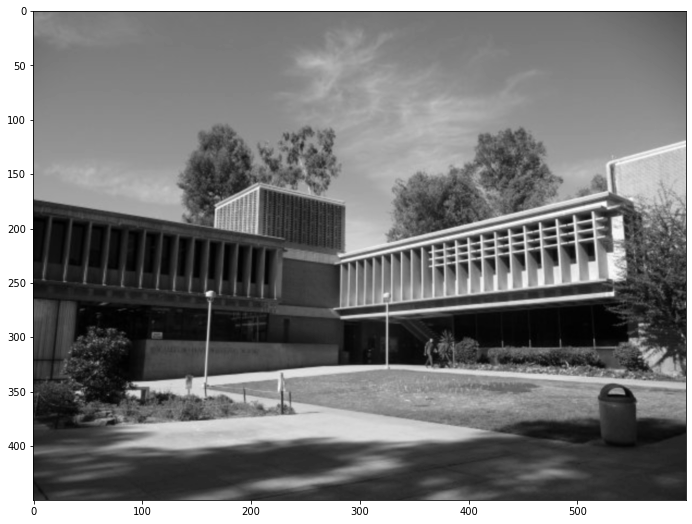

In [175]:
# load image file that we will be working on
# modify directory path string to accommodate "your" relative path.
img = cv2.imread('/Users/johnsonFreemanClarke/Pictures/cppEnvDesign.jpeg', 0)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.show()

## Step 1: Smooth original image

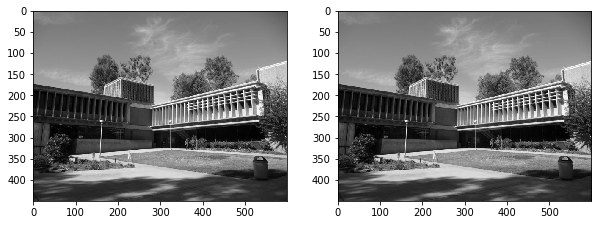

In [176]:
# We're allowed to use the cv2 GaussianBlur function for step 1
filter_size = (3,3) # (m, n) must be odd values
sigma = 0.2
blur = cv2.GaussianBlur(img, filter_size, sigma)
postPicsSideBySide(img, blur)

## Step 2: Compute Gradient magnitude and direction

In [177]:
# Using (3x3) sobel filters for x and y directions
# Condition: image should be converted to numpy array
# Returns: tuple of Matrices: (gradient magnitude, gradient radian)
def getGradient(image):    
    # We are permitted to use Sobel filters
    # x-direction
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    # y-direction
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    hypo_matrix = getHypotenuse(sobel_x, sobel_y)
    hypo_matrix = hypo_matrix/hypo_matrix.max() * 255 # normalize the gradient intensity values
    
    angle_matrix = np.arctan2(sobel_y, sobel_x) # first param (y) is numerator
    
    return (hypo_matrix, angle_matrix)

grad_tuple = getGradient(blur)

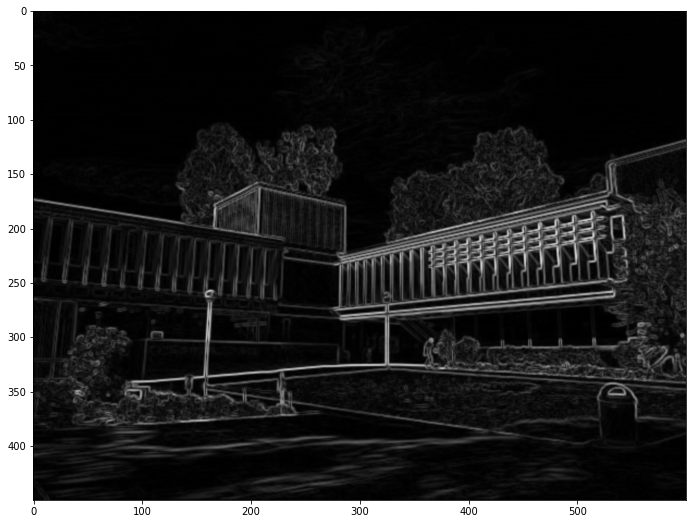

In [178]:
# grad_tuple[0] = gradient magnitudes
# grad_tuple[1] = gradient radians
plt.imshow(grad_tuple[0], cmap = 'gray', interpolation = 'bicubic')
plt.rcParams["figure.figsize"] = [15, 9]
plt.show()

### Step 3: Non-Maxima Suppression

In [179]:
# grad_img & grad_angles are matrices computed from getGradient function
# grad_intensities: gradient intensity image matrix 
# grad_radians: gradient matrix with radian values
def getNonMaximaSuppression(grad_intensities, grad_radians):
    rows = img.shape[0]
    cols = img.shape[1]
    
    # Create updated image to hold process of non maxima suppression
    updated_image = np.zeros((rows, cols), dtype=np.int32)
    
    angle_matrix = grad_radians.copy()
    angle_matrix *= 180 / np.pi # convert radians to angles
    
    for i in range(angle_matrix.shape[0]):
        for j in range(angle_matrix.shape[1]):
            if angle_matrix[i, j] < 0:
                angle_matrix[i, j] += 180 # we add 180 to get the positive version of the negative angle
    
    # Our logic for computing the non maxima suppression starts here
    # We keep in mind the graph from the lecture slides from 0 to 180 degrees
    for i in range(1, rows - 1): # we will stay within the image boundary
        for j in range(1, cols - 1):
            neighbor1 = 255 # at any given angle, there will always be two neighbors that we check for
            neighbor2 = 255
            
            # If angle is between [0, 22.5) or [157.5, 180]
            if (0 <= angle_matrix[i, j] < 22.5) or (157.5 <= angle_matrix[i, j] <= 180):
                neighbor1 = grad_intensities[i, j + 1]
                neighbor2 = grad_intensities[i, j - 1]
            # If angle is between [22.5, 67.5)
            elif (22.5 <= angle_matrix[i, j] < 67.5):
                neighbor1 = grad_intensities[i - 1, j - 1]
                neighbor2 = grad_intensities[i + 1, j + 1]
            # If angle is between [67.5, 112.5)
            elif (67.5 <= angle_matrix[i, j] < 112.5):
                neighbor1 = grad_intensities[i + 1, j]
                neighbor2 = grad_intensities[i - 1, j]
            # If angle is between [112.5, 157.5)
            elif (112.5 <= angle_matrix[i, j] < 157.5):
                neighbor1 = grad_intensities[i + 1, j - 1]
                neighbor2 = grad_intensities[i - 1, j + 1]
                
            if (grad_intensities[i, j] >= neighbor1) and (grad_intensities[i, j] >= neighbor2):
                updated_image[i, j] = grad_intensities[i, j]
            else:
                updated_image[i, j] = 0
    return updated_image

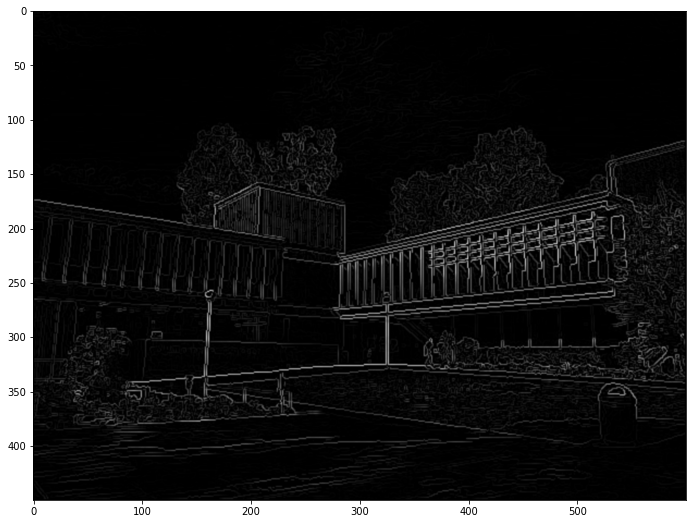

In [180]:
# grad_tuple[0] = gradient magnitudes
# grad_tuple[1] = gradient radians
step3image = getNonMaximaSuppression(grad_tuple[0], grad_tuple[1])
plt.imshow(step3image, cmap = 'gray', interpolation = 'bicubic')
# plt.rcParams["figure.figsize"] = [15, 9]
plt.show()

### Step 4: Hysteresis Thresholding

In [181]:
# Obtain strong-edge & weak edge matrix (high and low thresholding)
# returns: tuple of strong & weak edge matrices
def getThresholdEdges(non_maxima_matrix, high_ratio=0.2, low_ratio=0.1):
    # Find largest value in non_maxima_matrix
    largest = non_maxima_matrix.max()
    
    # Determines strong & weak edges
    high_thresh = 0.2 * largest 
    low_thresh = 0.1 * largest 
    
    # Create strong & weak edge matrix
    strong_edges = np.zeros((non_maxima_matrix.shape[0], non_maxima_matrix.shape[1]), dtype=np.uint8)
    weak_edges = np.zeros((non_maxima_matrix.shape[0], non_maxima_matrix.shape[1]), dtype=np.uint8)

    # Mark the strong and weak edges accordingly
    for i in range(non_maxima_matrix.shape[0]):
        for j in range(non_maxima_matrix.shape[1]):
            if non_maxima_matrix[i, j] >= high_thresh:
                strong_edges[i, j] = 255
            if(low_thresh <= non_maxima_matrix[i, j] < high_thresh):
                weak_edges[i, j] = 255
    return (strong_edges, weak_edges)

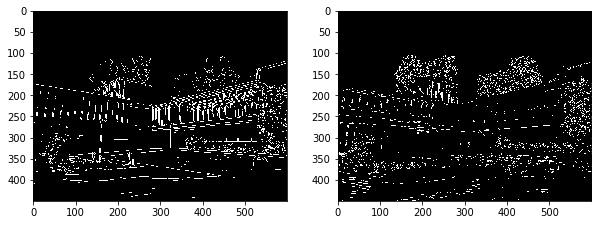

In [182]:
A = getThresholdEdges(step3image)
postPicsSideBySide(A[0], A[1]) # strong pixels(left), weak (right)

# We can view individual images of strong or weak edges in larger/detailed scale using the code below:
# A[0] represents strong edges, A[1] represents weak edges

# plt.imshow(A[0], cmap = 'gray', interpolation = 'bicubic')
# # plt.rcParams["figure.figsize"] = [15, 9]
# plt.show()

### Bonus Points consideration: deep search implementation used for linking edges

In [183]:
# Recursive function that checks for its neighbors
def checkWeakNeighbors(weak, updated, row, col):
  if (row < 0) or (col < 0):
    pass
  else:
    try:
      if weak[row, col] == 255:
        # set weak[row, col] to 0 to prevent future checks 
        weak[row, col] = 0
        updated[row, col] = 255
        # now check for weak links in a clock-wise fashion, starting from upper left
        checkWeakNeighbors(weak, updated, row-1, col-1) # upper left
        checkWeakNeighbors(weak, updated, row-1, col) # top 
        checkWeakNeighbors(weak, updated, row-1, col+1) # upper right
        checkWeakNeighbors(weak, updated, row, col-1) # left 
        checkWeakNeighbors(weak, updated, row, col+1) # right most
        checkWeakNeighbors(weak, updated, row+1, col-1) # bottom left
        checkWeakNeighbors(weak, updated, row+1, col) # bottom 
        checkWeakNeighbors(weak, updated, row+1, col+1) # bottom right
    except IndexError as e:
      pass
   

# just loop within image area (range row+1,row-1) (range(col+1, col-1)
# updated - represents the padded image
# resursion: if we encounter a strong edge, check weak matrix to recursively connect edges
def getHysteresis(strong, weak, updated):
  # need to check neighbors: upper left, top, upper  right, left, right, lower left, bottom, lower right
  for row in range(1,updated.shape[0]-1):
    for col in range(1, updated.shape[1]-1):
      if strong[row, col] == 255:
        updated[row, col] = 255
        # now check for weak links in a clock-wise fashion
        checkWeakNeighbors(weak, updated, row-1, col-1) # upper left
        checkWeakNeighbors(weak, updated, row-1, col) # top 
        checkWeakNeighbors(weak, updated, row-1, col+1) # upper right
        checkWeakNeighbors(weak, updated, row, col-1) # left 
        checkWeakNeighbors(weak, updated, row, col+1) # right most
        checkWeakNeighbors(weak, updated, row+1, col-1) # bottom left
        checkWeakNeighbors(weak, updated, row+1, col) # bottom 
        checkWeakNeighbors(weak, updated, row+1, col+1) # bottom right
  return updated

### My implementation of canny edge detection result

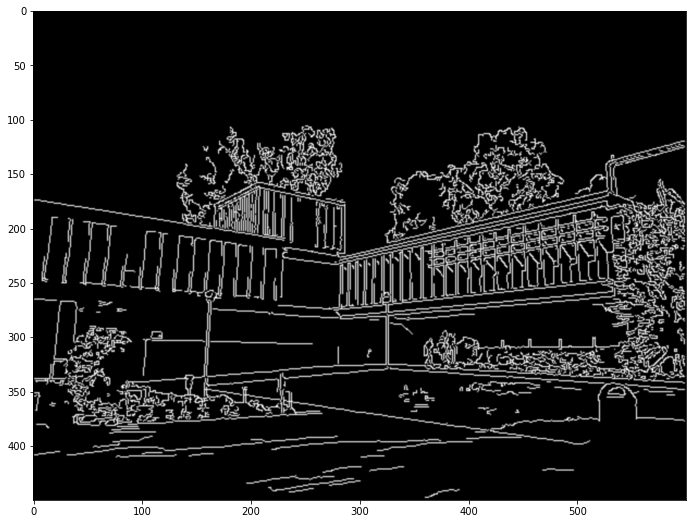

In [184]:
# We will update our strong edges, weak edges, and updated matrix with padding
strong_edges = A[0].copy()
strong_edges = padImage(strong_edges, 1) # pad image with border of zeros

weak_edges = A[1].copy()
weak_edges = padImage(weak_edges, 1)

# We could of also copied the strong_edges since it's the same dimensions as the weak_edges
updated = np.zeros((weak_edges.shape[0], weak_edges.shape[1]), dtype=np.uint8)

getHysteresis(strong_edges, weak_edges, updated)

# No we trim the borders off of the image by assigning result matrix to contain the slices 
# of updated matrix without the borders.
result = updated.copy()
result = result[1:result.shape[0]-1, 1:result.shape[1]-1]

plt.imshow(result, cmap = 'gray', interpolation = 'bicubic')
# # plt.rcParams["figure.figsize"] = [15, 9]
plt.show()

In [188]:
# save output of image
my_result = result.copy()
status = cv2.imwrite('/Users/johnsonFreemanClarke/Pictures/myCannyEdgeResult.jpeg', my_result)
if status != True:
    print('Please check your directory file path name and try again')

### Displaying cv2.Canny function result

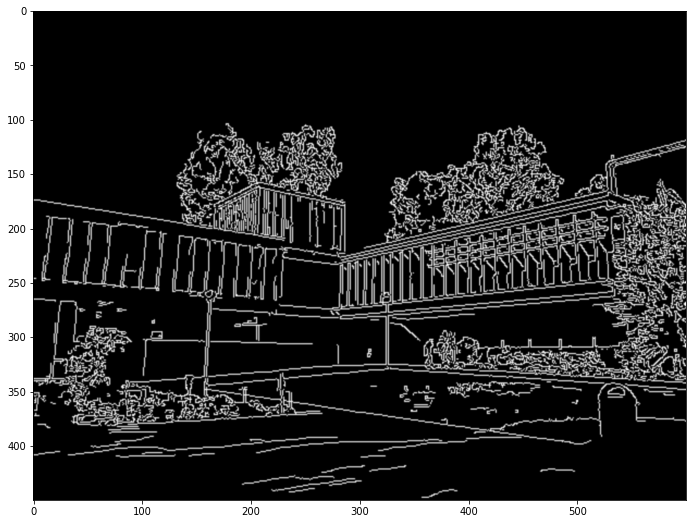

In [189]:
original_img = cv2.imread('/Users/johnsonFreemanClarke/Pictures/cppEnvDesign.jpeg', 0)
canny_result = cv2.Canny(original_img, 100, 200) # use blurred image from initial steps above
plt.imshow(canny_result, cmap = 'gray', interpolation = 'bicubic')
plt.show()

In [190]:
# save output of cv2.Canny resultant image
my_canny_result = canny_result.copy()
status = cv2.imwrite('/Users/johnsonFreemanClarke/Pictures/cv2CannyResult.jpeg', my_canny_result)
if status != True:
    print('Please check your directory file path name and try again')

### Displaying cv2.Laplacian function result

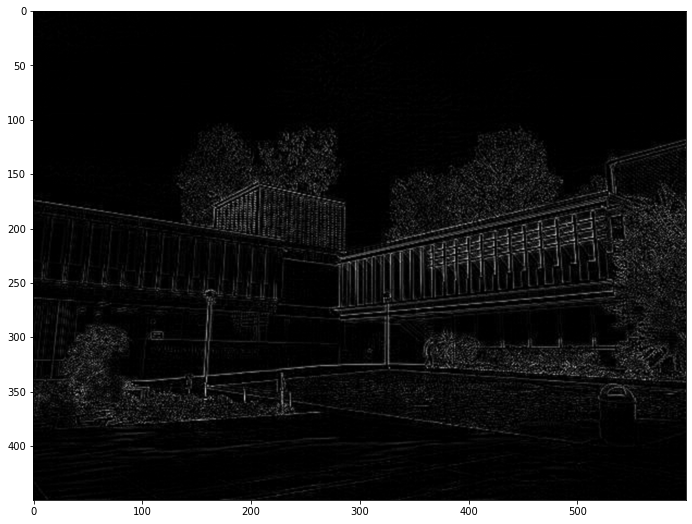

In [192]:
laplacian_img = cv2.Laplacian(blur, cv2.CV_8U, 3) # where kernel_size = 3
plt.imshow(laplacian_img, cmap = 'gray', interpolation = 'bicubic')
plt.show()

In [193]:
# save output of cv2.Laplacian resultant image
my_laplacian_result = laplacian_img.copy()
status = cv2.imwrite('/Users/johnsonFreemanClarke/Pictures/cv2LaplacianResult.jpeg', my_laplacian_result)
if status != True:
    print('Please check your directory file path name and try again')

# Comparison:
A Comparison of my implementation of the canny edge detection with the cv2.Canny function results in a similar outcome. There are a few exceptions; the cv2.Canny outcome contains a few more edges in certain areas, this might be a factor from fine tuning my Gaussian blurred image (variability: sigma, kernel size, picture). My implementation has the recursive steps of linking strong and weak edges together.

The openCV documentation/examples for the Laplacian function first smoothes an existing original image before applying the cv2.Laplacian function to that image. Thus, an image is produced that is notably less intensified in the overall region of the image. 